In [251]:
import numpy as np
from matplotlib import pyplot as plt
from dataclasses import dataclass
from models.FITS import FITS
from torch import optim
from torch import nn
import torch

In [252]:
# model
seq_len = 720
pred_len = 360
n_epochs = 500
batch_size = 64
n_features = 1

# data
n_samples = 4000 * 8
seasonal_period = 900

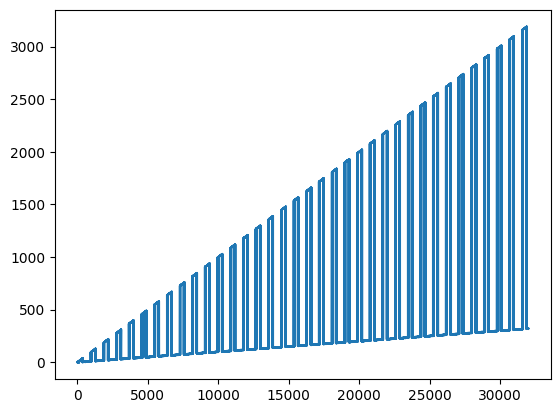

In [253]:
t = np.arange(n_samples)
seasonal_effect = 10 * np.sin(2 * np.pi * t / seasonal_period)
noise = np.random.normal(0, 1, n)
data_seasonal = seasonal_effect + noise

threshold_effect = np.piecewise(
    t, [data_seasonal < 5, data_seasonal >= 5], [lambda t: t * 0.01, lambda t: t * 0.1]
)
data_threshold_effect = threshold_effect + noise

plt.plot(t, data_threshold_effect)
plt.show()

In [254]:
@dataclass
class Config:
    dominance_freq = 20
    individual = False
    debug = False
    channels = n_features
    seq_len = seq_len
    pred_len = pred_len

In [255]:
model = FITS(Config)
# initiate the model parameters as 0 for better visualization
for param in model.parameters():
    param.data.fill_(0)

In [256]:
model_optim = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

In [257]:
y = data_threshold_effect
y = (y - y.mean()) / y.std()

In [258]:
for epoch in range(n_epochs):
    order = np.random.permutation(n_samples // 2)  # shuffle the training sample
    train_loss = []
    for batch in range(25):
        batch_start = order[batch * batch_size : (batch + 1) * batch_size]
        batch = []
        for i in batch_start:
            batch.append(y[i : i + seq_len + pred_len])
        batch_xy = np.array(batch).reshape(batch_size, seq_len + pred_len, n_features)

        batch_xy = torch.from_numpy(batch_xy).float()  # .to("cuda:0")

        batch_x = batch_xy[:, :seq_len, :]
        batch_y = batch_xy[:, seq_len:, :]

        model_optim.zero_grad()

        output = model(batch_x)

        loss = criterion(
            output, batch_xy
        )  # supervise on xy (only supervise on y also achieve the same result)

        train_loss.append(loss.item())

        loss.backward()

        model_optim.step()

    print(f"\repoch: {epoch} loss: {np.mean(train_loss):1f}", flush=True, end="")

epoch: 499 loss: 0.024218

In [259]:
output = output.cpu().detach().numpy()
batch_xy = batch_xy.cpu().detach().numpy()

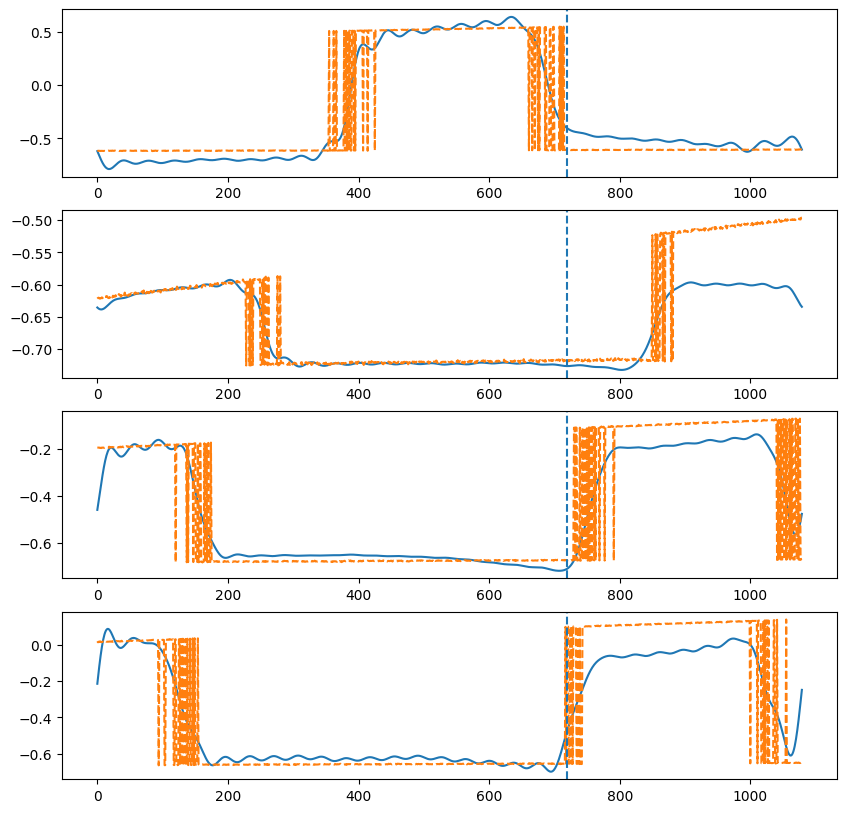

In [260]:
plt.figure(figsize=(10, 10))
plt.subplot(4, 1, 1)
plt.plot(output[0, :, 0])  # prediction
plt.plot(batch_xy[0, :, 0], "--")  # ground truth
plt.axvline(seq_len, linestyle="--")
plt.subplot(4, 1, 2)
plt.plot(output[1, :, 0])
plt.plot(batch_xy[1, :, 0], "--")
plt.axvline(seq_len, linestyle="--")
plt.subplot(4, 1, 3)
plt.plot(output[2, :, 0])
plt.plot(batch_xy[2, :, 0], "--")
plt.axvline(seq_len, linestyle="--")
plt.subplot(4, 1, 4)
plt.plot(output[3, :, 0])
plt.plot(batch_xy[3, :, 0], "--")
plt.axvline(seq_len, linestyle="--")

# Test set

In [270]:
with torch.no_grad():
    model.eval()
    test_loss = []
    batch = []

    for i in range(
        (n_samples // 2) + seq_len + pred_len, n_samples - seq_len - pred_len
    ):
        batch.append(y[i : i + seq_len + pred_len])
    batch_xy = np.array(batch).reshape(
        -1, seq_len + pred_len, 1
    )  # 80 batch_size, 360 time steps, 1 feature

    batch_xy = torch.from_numpy(batch_xy).float()

    batch_x = batch_xy[:, :seq_len, :]
    batch_y = batch_xy[:, seq_len:, :]

    model_optim.zero_grad()

    output = model(batch_x)

    # output=output[:,-120:,:]

    loss = criterion(
        output, batch_xy
    )  # supervise on xy (only supervise on y also achieve the same result)

    test_loss.append(loss.item())

    print("epoch: test loss: ", np.mean(test_loss))

epoch: test loss:  0.16676616668701172


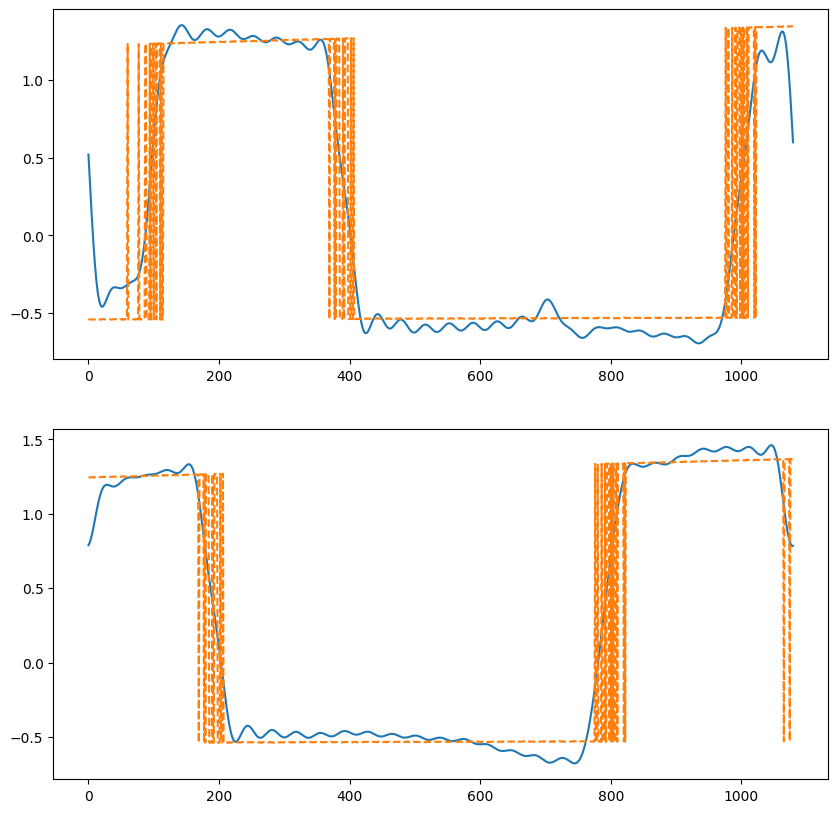

In [271]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 1, 1)
plt.plot(output[0, :, 0])  # prediction
plt.plot(batch_xy[0, :, 0], "--")  # ground truth
plt.subplot(2, 1, 2)
plt.plot(output[200, :, 0])
plt.plot(batch_xy[200, :, 0], "--")